In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Baffin = pd.read_excel(filepath, sheet_name='Baffin-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Baffin)
fp.date_time(Baffin)

,Extent,Date
0,1090625.815,1979-01-01
1,1157634.866,1979-02-01
2,1299583.477,1979-03-01
3,1137194.680,1979-04-01
4,983083.453,1979-05-01
...,...,...
533,781460.891,2023-06-01
534,331845.048,2023-07-01
535,99334.625,2023-08-01
536,49359.723,2023-09-01


In [5]:
scaler = MinMaxScaler()
Baffin['Extent'] = scaler.fit_transform(Baffin['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 12
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Baffin['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((515, 12, 1), (515,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Baffin_model_LT12/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 20s 235ms/step - loss: 0.2336 - root_mean_squared_error: 0.4833 - val_loss: 0.1818 - val_root_mean_squared_error: 0.4264
Epoch 2/50
53/53 [==============================] - 10s 201ms/step - loss: 0.1382 - root_mean_squared_error: 0.3717 - val_loss: 0.0750 - val_root_mean_squared_error: 0.2739
Epoch 3/50
53/53 [==============================] - 11s 208ms/step - loss: 0.0814 - root_mean_squared_error: 0.2853 - val_loss: 0.0683 - val_root_mean_squared_error: 0.2613
Epoch 4/50
53/53 [==============================] - 12s 223ms/step - loss: 0.0740 - root_mean_squared_error: 0.2720 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2448
Epoch 5/50
53/53 [==============================] - 13s 240ms/step - loss: 0.0642 - root_mean_squared_error: 0.2533 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2232
Epoch 6/50
53/53 [==============================] - 11s 214ms/step - loss: 0.0540 - root_mean_squared_error: 0.2325 - val_loss: 0.0377 

Epoch 33/50
53/53 [==============================] - 11s 206ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540
Epoch 34/50
53/53 [==============================] - 1s 26ms/step - loss: 0.0125 - root_mean_squared_error: 0.1119 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0790
Epoch 35/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0126 - root_mean_squared_error: 0.1122 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 36/50
53/53 [==============================] - 1s 26ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0721
Epoch 37/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 38/50
53/53 [==============================] - 1s 28ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0041 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.872066183884939 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

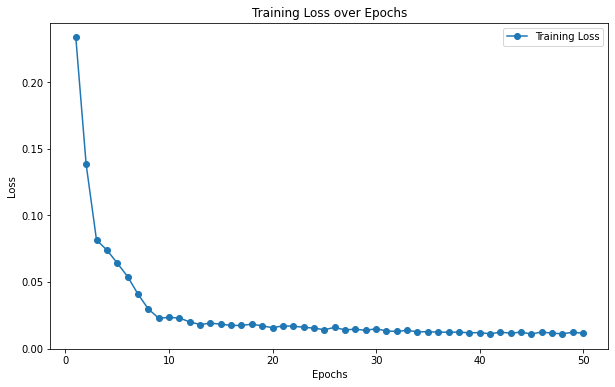

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

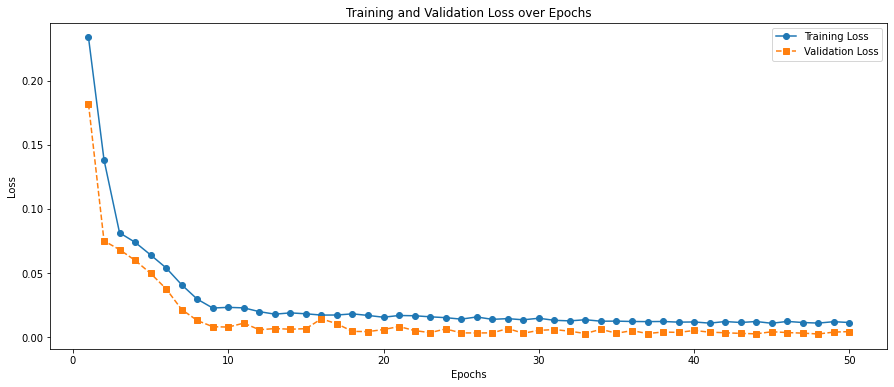

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Baffin_model_LT12/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 20ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.0698074980000937
MAE : 0.05798905229210136


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.251319e+06,1036981.003
1,1.060880e+06,847489.150
2,6.683902e+05,619129.338
3,3.056517e+05,195688.491
4,6.239685e+04,36670.811
5,5.976635e+04,31777.310
6,2.824711e+05,82762.022
7,5.438452e+05,400043.823
8,8.177945e+05,733089.555
9,1.048068e+06,917362.266


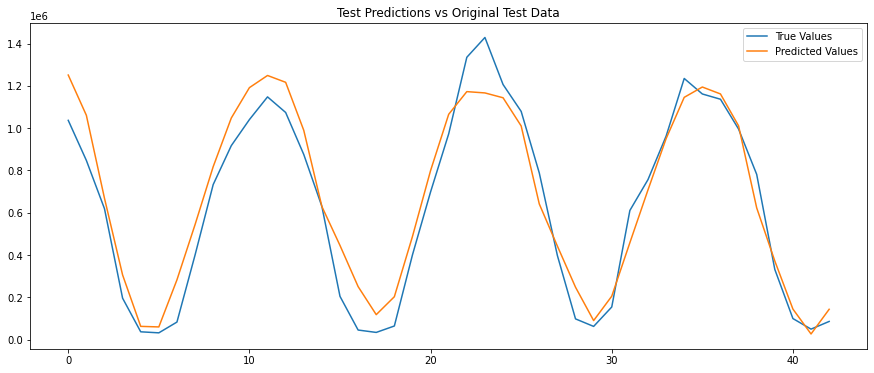

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 15ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

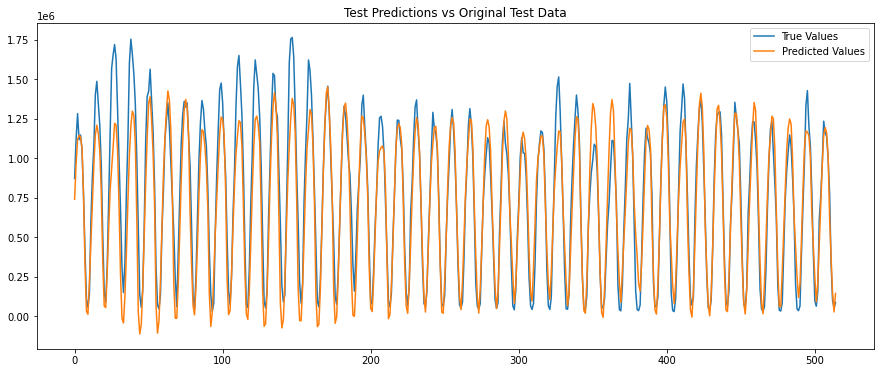

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()